In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [2]:
# Simple recomender
md = pd. read_csv('../dataset/movies_metadata.csv')
md.head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0


In [3]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [4]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
print(C)

5.244896612406511


Text(0.5, 0, 'vote_count')

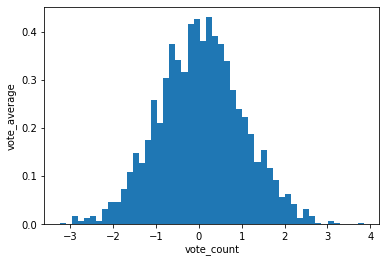

In [5]:
np.random.seed(42)
x = np.random.normal(size=2000)
plt.hist(x, density=True, bins=50)
plt.ylabel('vote_average')
plt.xlabel('vote_count')

In [6]:
m = vote_counts.quantile(0.96)
print(m)

576.6399999999994


In [7]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(1819, 6)

In [9]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [10]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [11]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [12]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.891568
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.876324
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.864948
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.845075
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.832214
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.828186
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.822186
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.819520
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.817885
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.806672


In [13]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [14]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [15]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [16]:
# content based recomender
links_small = pd.read_csv('../dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [17]:
md = md.drop([19730, 29503, 35587])

In [18]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [19]:
smd = md[md['id'].isin(links_small)]
print(smd.shape)

(9099, 25)


In [20]:
# Movie Description Based Recommender
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [21]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [22]:
print(tfidf_matrix.shape)

(9099, 268124)


In [23]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
print(cosine_sim[0])

[1.         0.00680476 0.         ... 0.         0.00344913 0.        ]


In [25]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [26]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [27]:
get_recommendations('Interstellar').head(10)

4208       Suburban Commando
1312                 Gattaca
4442     Final Destination 2
3056           Space Cowboys
7669         All Good Things
282                 Stargate
8032              Prometheus
2631    They Might Be Giants
1260                   Spawn
1329       Starship Troopers
Name: title, dtype: object

In [28]:
get_recommendations('Inception').head(10)

5239                              Cypher
141                                Crumb
6398                         Renaissance
653                            Lone Star
1703                               House
4739                    The Pink Panther
319                                 Cobb
2828    What Ever Happened to Baby Jane?
8867                     Pitch Perfect 2
979          Once Upon a Time in America
Name: title, dtype: object

In [29]:
# Meta data based recomender
credits = pd.read_csv('../dataset/credits.csv')
keywords = pd.read_csv('../dataset/keywords.csv')

In [30]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [31]:
print(md.shape)

(45463, 25)


In [32]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [33]:
smd = md[md['id'].isin(links_small)]
print(smd.shape)

(9219, 28)


In [34]:
# crew and cast
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [35]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [36]:
smd['director'] = smd['crew'].apply(get_director)

In [37]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [38]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [39]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [40]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [41]:
# keywords
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [42]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [43]:
s = s[s > 1]

In [44]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [45]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [46]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [47]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [48]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [49]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [50]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [51]:
get_recommendations('Interstellar').head(10)

7648                Inception
2085                Following
6623             The Prestige
6981          The Dark Knight
3381                  Memento
4145                 Insomnia
8031    The Dark Knight Rises
4153           Silent Running
6218            Batman Begins
8983              The Martian
Name: title, dtype: object

In [52]:
get_recommendations('Inception').head(10)

6623                             The Prestige
3381                                  Memento
4145                                 Insomnia
2085                                Following
8031                    The Dark Knight Rises
8613                             Interstellar
6981                          The Dark Knight
6218                            Batman Begins
5638    Sky Captain and the World of Tomorrow
8500                                  Don Jon
Name: title, dtype: object

In [53]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [54]:
improved_recommendations('Interstellar')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.891568
6981,The Dark Knight,12269,8,2008,7.876324
6623,The Prestige,4510,8,2006,7.687671
3381,Memento,4168,8,2000,7.665158
8031,The Dark Knight Rises,9263,7,2012,6.897144
6218,Batman Begins,7511,7,2005,6.874863
8983,The Martian,7442,7,2015,6.873786
756,2001: A Space Odyssey,3075,7,1968,6.722847
8384,Oblivion,4862,6,2013,5.919939
8854,Terminator Genisys,3677,5,2015,5.033199


In [55]:
improved_recommendations('Inception')

,title,vote_count,vote_average,year,wr
6981,The Dark Knight,12269,8,2008,7.876324
8613,Interstellar,11187,8,2014,7.864948
6623,The Prestige,4510,8,2006,7.687671
3381,Memento,4168,8,2000,7.665158
8031,The Dark Knight Rises,9263,7,2012,6.897144
6218,Batman Begins,7511,7,2005,6.874863
4173,Minority Report,2663,7,2002,6.687600
8207,Looper,4777,6,2012,5.918668
7286,X-Men Origins: Wolverine,4086,6,2009,5.906615
7903,Green Lantern,2551,5,2011,5.045151


In [56]:
# Collaborative Filtering
reader = Reader()
ratings = pd.read_csv('../dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [57]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# data.split(n_folds=5)

In [58]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8920  0.8992  0.8927  0.8967  0.8994  0.8960  0.0031  
MAE (testset)     0.6864  0.6898  0.6895  0.6901  0.6941  0.6900  0.0024  
Fit time          4.27    5.73    5.68    5.16    4.43    5.05    0.61    
Test time         0.14    0.15    0.11    0.12    0.25    0.15    0.05    


{'test_rmse': array([0.89200119, 0.89919096, 0.89272531, 0.89674294, 0.89936457]),
 'test_mae': array([0.6864422 , 0.689834  , 0.68947567, 0.69008213, 0.69412443]),
 'fit_time': (4.270570755004883,
  5.729519844055176,
  5.683542013168335,
  5.15916633605957,
  4.431554317474365),
 'test_time': (0.14265084266662598,
  0.14664173126220703,
  0.11301875114440918,
  0.11733746528625488,
  0.25356101989746094)}

In [59]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [60]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [61]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.5240174611886146, details={'was_impossible': False})

In [62]:
# Hybrid Recommender
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [63]:
id_map = pd.read_csv('../dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [64]:
indices_map = id_map.set_index('id')

In [67]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [68]:
hybrid(1, 'Aliens')

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.087963
987,Alien,4564.0,7.9,1979,348,3.032925
3935,Impostor,136.0,6.1,2001,4965,2.907249
1011,The Terminator,4208.0,7.4,1984,218,2.859904
6640,Déjà Vu,1519.0,6.6,2006,7551,2.856039
922,The Abyss,822.0,7.1,1989,2756,2.812092
7488,Avatar,12114.0,7.2,2009,19995,2.734490
7498,Daybreakers,646.0,6.0,2009,19901,2.714253
7828,I Am Number Four,1606.0,5.9,2011,46529,2.637599
7939,Gantz,73.0,6.5,2011,56832,2.608473


In [69]:
hybrid(500, 'Aliens')

,title,vote_count,vote_average,year,id,est
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.344579
6967,Doomsday,374.0,5.8,2008,13460,3.344354
987,Alien,4564.0,7.9,1979,348,3.299576
8468,Riddick,2066.0,6.2,2013,87421,3.248130
7939,Gantz,73.0,6.5,2011,56832,3.223737
6905,I Am Legend,4977.0,6.9,2007,6479,3.081382
7828,I Am Number Four,1606.0,5.9,2011,46529,3.040592
344,True Lies,1138.0,6.8,1994,36955,3.035195
8042,The Darkest Hour,474.0,4.8,2011,71469,3.032956
1360,Alien: Resurrection,1388.0,5.9,1997,8078,2.990499


# Conclusion

Simple Recommender: This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.

Content Based Recommender: Out of two content based engines, one took movie overview and taglines as input and the other took metadata such as cast, crew, genre and keywords to come up with predictions. 

Collaborative Filtering: Here the powerful Surprise package is used to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.

Hybrid Engine: Combining the ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.